# Bag of Words Model

**Objective**

- Define 'bag of words'
- Build, fit, and evaluate a bag of words neural network

A bag of words model **uses a count vectorizer** and the frequency of terms in the document as the input into the model. The order of the words is not preserved.

### Imports, functions

In [1]:
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
import pandas as pd
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [6]:
## Load the autoreload extension
%load_ext autoreload 
%autoreload 2

import custom_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Filter the data. We will work with the prior Yelp data, limited to 2018,  English, and 1, 3, and 5-star reviews.

### Preparing the Data

**Filtering**

In [8]:
# Load Data from your path
df = pd.read_csv("Data/yelp-restaurant-reviews-CA-2015-2018.csv.gz", index_col = 'date', parse_dates=['date'])
## Remove any non-english reivews
df = df.loc[ df['language']=='en'].copy()
# Keep only 1,3,5 star reviews
df = df.loc[ df['stars'].isin([1,3,5])]
# Take a smaller subset
df = df.loc['2018']
# Set the index
df = df.set_index('review_id')
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 17317 entries, Ebl0LmHkLsQk9hP0rBm3GA to Fbzo2Z8CfH8naCbEPPhREw
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  17317 non-null  object
 1   text         17317 non-null  object
 2   stars        17317 non-null  int64 
 3   language     17317 non-null  object
dtypes: int64(1), object(3)
memory usage: 676.4+ KB


,business_id,text,stars,language
review_id,,,,
Ebl0LmHkLsQk9hP0rBm3GA,KSYONgGtrK0nKXfroB-bwg,"Ate here twice and had both atmosphere and great tapas. The Jamon plate, bravas, Spanish omelette, stuffed date, pork, Brussels sprouts, wine and amazing pear dessert...I could go on and on. If visiting, Please make a reservation as soon as you a...",5,en
DBa7PNBoBGJMc2qXXl4pRA,54oLdsGU9B8HxFTqCCqV-A,"My boyfriend and I got recommended this place by a SB local! We were just amazed! Everything from the look and feel of the place to the appetizer to the main dish, the dessert and the service was just perfect! Our food was just amazing!!!",5,en


Further filter the dataset by eliminating long reviews. First check the length of each review. Do this with a lambda function that splits on spaces and obtains the length. Add the data as a column in the dataframe.

In [10]:
# Let's take a look at the length of the each text
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head(2)

,business_id,text,stars,language,sequence_length
review_id,,,,,
Ebl0LmHkLsQk9hP0rBm3GA,KSYONgGtrK0nKXfroB-bwg,"Ate here twice and had both atmosphere and great tapas. The Jamon plate, bravas, Spanish omelette, stuffed date, pork, Brussels sprouts, wine and amazing pear dessert...I could go on and on. If visiting, Please make a reservation as soon as you a...",5,en,67
DBa7PNBoBGJMc2qXXl4pRA,54oLdsGU9B8HxFTqCCqV-A,"My boyfriend and I got recommended this place by a SB local! We were just amazed! Everything from the look and feel of the place to the appetizer to the main dish, the dessert and the service was just perfect! Our food was just amazing!!!",5,en,45


In [11]:
# Examine general statistics
df['sequence_length'].describe()

count    17317.000000
mean        81.066178
std         76.381545
min          6.000000
25%         33.000000
50%         58.000000
75%        101.000000
max       1006.000000
Name: sequence_length, dtype: float64

The shortest review is 6 words, while the longest review is 1006. The average review is 81 words. Let's visualize with a histogram.

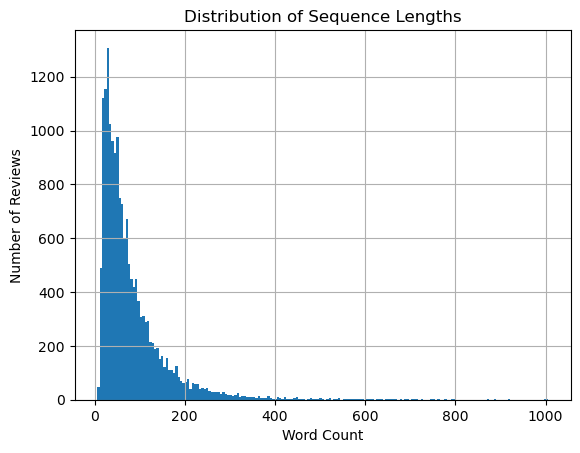

In [12]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

We can see that most reviews are less than 400 words, but there are clearly some lengthier ones! We will create a filter for texts less than 400 words.

In [13]:
# Define a filter to identify reviews less than 400 words
filter_short = df['sequence_length']< 400
print(f'Number of reviews >400 words is: {len(df) - filter_short.sum()}')

Number of reviews >400 words is: 149


In [16]:
# Keep short reviews (<400 words)
df = df.loc[filter_short]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17168 entries, Ebl0LmHkLsQk9hP0rBm3GA to Fbzo2Z8CfH8naCbEPPhREw
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_id      17168 non-null  object
 1   text             17168 non-null  object
 2   stars            17168 non-null  int64 
 3   language         17168 non-null  object
 4   sequence_length  17168 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 804.8+ KB


**Class Balance**

In [17]:
# Check class balance
df['stars'].value_counts()

5    12963
1     2357
3     1848
Name: stars, dtype: int64

The classes are dramatically imbalanced. We will address this with the RandumUnderSampler().

In [18]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df_ml,  _ = sampler.fit_resample(df, df['stars'])
df_ml['stars'].value_counts()

1    1848
3    1848
5    1848
Name: stars, dtype: int64

### Train Test Split

In [19]:
# Define X
X = df_ml['text'].values
# Create a map for targets
target_map = {1:0,
              3:1,
              5:2}
# DEfine y and apply the target_map
y = df_ml['stars'].map(target_map)
y.value_counts()

0    1848
1    1848
2    1848
Name: stars, dtype: int64

We will also define a classes variable for future use in our model.

In [20]:
# Define classes variable
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

Convert to a Dataset object and Perform the Train, Test, Validation Split

In [21]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))
# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False)

Now, we will define the ratios for our train, validation, and test split. We will calculate how many samples for each.

In [22]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

In [25]:
# For our reference, we will print how many samples and how many batches for each set.
import math
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	3880 samples 	(122 batches)
    - val:  	1108 samples 	(35 batches)
    - test: 	556 samples 	(18 batches)


In [26]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [27]:
# Confirm len of train_ds
len(train_ds)

122

### Make and fit TextVectorizer layer

We will define a custom function to make the text vectorization layer. The function instantiates the layer and uses the .adapt method to build the vocabulary on the training data. It also creates a dictionary of the vocabulary.

In [28]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str

We will use the function to create a count vectorizer and adapt it to the training_ds.

In [29]:
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
count_vectorizer, count_lookup = make_text_vectorization_layer(train_ds, output_mode='count', verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization',
    'ngrams': None,
    'output_mode': 'count',
    'output_sequence_length': None,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 13460}
)


In [30]:
# Check the size of the vocabulary
len(count_vectorizer.get_vocabulary())

13460

### Build, Fit, and Evaluate the Model

**Define a Model Buiulding Function**

As we introduced in Intermediate Machine Learning,  we will build our models within a function. Notice that we are including the text_vectorization layer as an argument in our function. This will allow us to change the vectorization outputs and other parameters easily. You should define model build functions within the notebook (not in a separate custom_functions .py) because we do not include arguments for the many parameters that we may want to use when building our models.

In [31]:
from tensorflow.keras import layers, optimizers, regularizers
def build_bow_model(text_vectorization_layer, name=None):
    # Build model with pre-trained text_vectorization layer
    bow_model = tf.keras.models.Sequential([
        text_vectorization_layer], name=name)
   
    # Add layers
    bow_model.add(layers.Dense(32, activation='relu')),
    # Output layers
    bow_model.add(layers.Dense(len(classes), activation='softmax'))
    # Compile model
    bow_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer = optimizers.legacy.Adam(),
        metrics=['accuracy']
    )
    
    bow_model.summary()
    return bow_model

We will also want to define callbacks as we did with Intermediate Machine Learning.

In [32]:
# Code below is from Week 4 of Intermediate Machine Learning
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Finally, we will call the build function to build our model. We will also fit and evaluate the model in the next code block. Notice that we include the count_vectorizer we made and fit earlier. We also called our evaluate_classification_network function from our imported .py file with "fn."

Model: "BoW-Counts"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 13460)            0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 32)                430752    
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 430,851
Trainable params: 430,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
122/122 [==============================] - 1s 6ms/step - loss: 0.6942 - accuracy: 0.7402 - val_loss: 0.5081 - val_accuracy: 0.7987
Epoch 2/30
122/122 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.9134 - val_

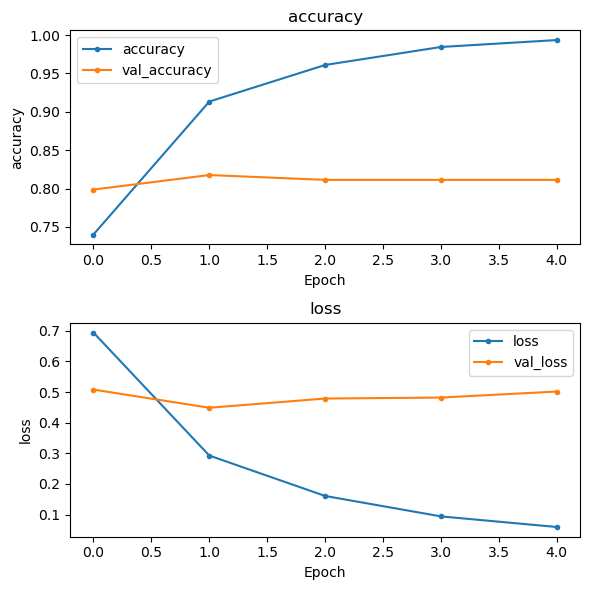


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1274
           1       1.00      1.00      1.00      1283
           2       1.00      1.00      1.00      1323

    accuracy                           1.00      3880
   macro avg       1.00      1.00      1.00      3880
weighted avg       1.00      1.00      1.00      3880



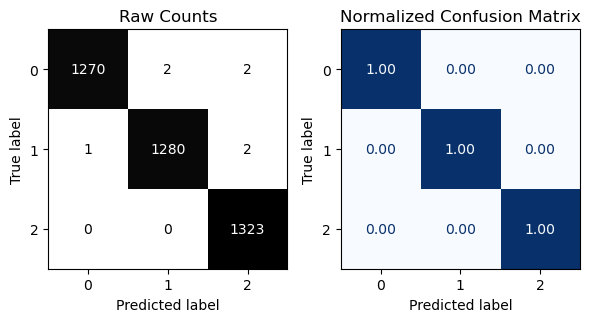


- Evaluating Training Data:
122/122 [==============================] - 0s 2ms/step - loss: 0.0400 - accuracy: 0.9982
{'loss': 0.039972174912691116, 'accuracy': 0.9981958866119385}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       195
           1       0.76      0.71      0.74       191
           2       0.89      0.92      0.90       170

    accuracy                           0.82       556
   macro avg       0.82      0.82      0.82       556
weighted avg       0.81      0.82      0.82       556



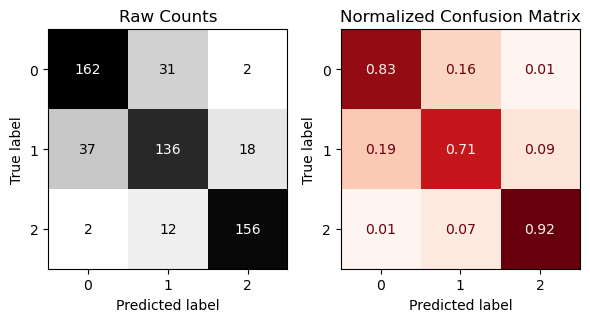


- Evaluating Test Data:
18/18 [==============================] - 0s 2ms/step - loss: 0.5477 - accuracy: 0.8165
{'loss': 0.5477449297904968, 'accuracy': 0.8165467381477356}


In [33]:
# Build the model with the adapted TextVectorizer
bow_model = build_bow_model(count_vectorizer, name="BoW-Counts")
# How many epochs?
EPOCHS = 30
# Fit the model with callbacks and save history
history = bow_model.fit(
    train_ds,
    epochs=EPOCHS,callbacks=get_callbacks(),
    validation_data=val_ds)
# Evaluate the model with a custom function
fn.evaluate_classification_network(
    bow_model, X_train=train_ds, 
    X_test=test_ds, history=history
);